# Comparison of Quspin time evolution with that of the BGS hamiltonian


In [1]:
import sys
import os
sys.path.append("../../../../src/")
#Imports
import numpy as np
import scipy as sp
import numpy.linalg as la
import matplotlib.pyplot as plt
#Custom made imports
import single_particle_sector as sps
from time import time

In [2]:
#Ground State Fidelity
def overlap(U,V):
    L = U.shape[0]//2
    U = U[:,:L]
    V = V[:,:L]
    overlap_matrix = U.conj().T @ V
    return la.det(overlap_matrix)
def evolve_TFIM_states(taus, N_steps, h0, hf, J, L, sps):
    Ut_tau = []
    GS_T_tau = []
    times_tau = []

    for tau in taus:
        times = np.linspace(0, tau, N_steps)
        Ut = sps.TFIM_time_evolve(N_steps, tau, h0, hf, J, L)

        GS_T = []
        for ti in range(N_steps):
            h = sps.h_t(times[ti], tau, h0, hf)
            H = sps.H_bdg(h, L, J)
            _, V = la.eigh(H)
            GS_T.append(V)

        Ut_tau.append(Ut)
        GS_T_tau.append(GS_T)
        times_tau.append(times)

    return Ut_tau, GS_T_tau, times_tau



In [3]:
#Model Parameters
L = 8
J = -1
h0 = 0
hf = 5
taus = np.array([1,10,100])
N_steps = 500

#Time Evolved States:
Ut_tau,GS_T_tau,times_tau= evolve_TFIM_states(taus, N_steps, h0, hf, J, L, sps);

/home/kristian/miniconda3/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `dtype`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


/home/kristian/Desktop/Subsystem Loschmidt Echo/subsystem_loschmidt_echo/scripts/mutual_info/exact_diag/Adiabatic Tests/../../../../src/single_particle_sector.py:184: ComplexWarning: Casting complex values to real discards the imaginary part
  C[nx,ny] = M[Bx,Ay]


IndexError: index 8 is out of bounds for axis 1 with size 8

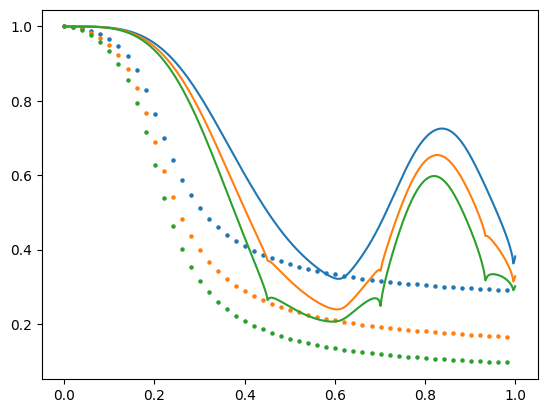

In [ ]:
ns = [2,3,4,5,6]
#i = time step
for j in range(0,len(taus)):
    plt.figure()    
    G_t =[sps.G_tfim(Ut_tau[j][ti][:,:L]) for ti in range(N_steps) ]
    G_gs = [sps.G_tfim(GS_T_tau[j][ti][:, :L]) for ti in range(N_steps)]
    #fidelity = [np.abs(overlap(Ut_tau[j][ti],GS_T_tau[j][0]))**2 for ti in range(N_steps)]
    for n in ns:
        P_t= [sps.P_n(n,Gi,L) for Gi in G_t]
        P_gs=[sps.P_n(n,Gi,L) for Gi in G_gs]
        plt.scatter(times_tau[j][::10],P_gs[::10], s = 5)
        plt.plot(times_tau[j],P_t, label = f"{n}")
    ##Plotting
    #plt.plot(times_tau[j],fidelity, label =f"Fidelity", color = "black",linestyle="--" )
    plt.title(f"P{n} , L = {L}, tau = {taus[j]}")
    plt.legend()
    plt.xlim(times_tau[j][0],times_tau[j][-1])
    plt.ylim(0,1)
    plt.show()

# Quspin Evolution

In [5]:
#Imports
import sys,os
os.environ['MKL_NUM_THREADS'] = '4' # set number of MKL threads to run in parallel
from quspin.operators import hamiltonian,quantum_operator
from quspin.basis import spin_basis_1d
from numpy.random import uniform,seed
from itertools import combinations
from functools import partial
import numpy as np
from time import time
from quspin.tools.measurements import diag_ensemble
from quspin.tools.evolution import ED_state_vs_time
import matplotlib.pyplot as plt
from quspin.tools.lanczos import lanczos_full, expm_lanczos
timestamp = time()

In [6]:
###Functions
def timer(timestamp):
    #Timer Function
    print("time =", time()-timestamp)
    return

def fin_string(ns,s): #ns = length of string s = operator
    #Max string length
    if ns>L:
        ns=L
    else:
        pass
    
    
    def linears(start,m):
        #Find all indices in string
        ind=[i%L for i in range(start,start+ns)]
     #All combinations
        perm=list(combinations(ind,m))
      #Add each coupling to operator
        for j in range(len(perm)):
#            S_temp=[((-1)**m)*(2**m)/(L*(2**ns))] ########### Down #
            S_temp=[1/(L*(2**ns))] ###################### Up
            for i in range(len(perm[j])):
                S_temp.append(perm[j][i])
        ##Saving Couplin gs lists
            if j==0: 
                S_temp_2=[S_temp]
            else: 
                S_temp_2.append(S_temp)
        return S_temp_2
    #List to store orders of interaction
    o_type=np.empty(ns,dtype=object)
    
    for i in range(ns):
        #ex: "z"*2= "zz"
        o_type[i]=s*(i+1)

    #Iterate over each Site
    for k in range(L):
        #Iterate over different string lengths
      for i in range(ns):
          #First item defines list
          if k==0 and i==0:
              #example: i = 0 operator_list = [['x', linears(k,1)]]
              operator_list=[[o_type[i],linears(k,i+1)]]
          else:
              operator_list.append([o_type[i],linears(k,i+1)])
    S_temp_1 = [[(1/((ns*2**ns))), i] for i in range(ns)]
    #S_temp_1 = [[(1/((ns*2**(ns)))), 1] ]
    operator_list.append(["I",S_temp_1])
    operator_dict=dict(S=operator_list)
    O = quantum_operator(operator_dict,basis=basis,check_symm=False,check_herm=False)
    return O, operator_list




def adiabatic_lanczos_evolution(H, h0, hf, tau, steps=200, krylov_dim=15):
    """
    Perform adiabatic time evolution using Lanczos approximation.

    Parameters:
        H           : quspin operator_dict Hamiltonian object
        h0          : initial field value
        hf          : final field value
        tau         : total evolution time
        steps       : number of time steps
        krylov_dim  : dimension of Krylov subspace

    Returns:
        v_t_list    : list of evolved states at each time
        V0          : initial ground state
        Vf[:,0]     : final ground state
        times       : array of time values
        h_vals      : array of h(t) values
    """
    # initial Hamiltonian and ground state
    H0 = H.tohamiltonian(dict(H0=1, Quench=h0))
    E0, V0_full = np.linalg.eigh(H0.todense())
    V0 = np.array(V0_full)[:, 0]
    # time grid
    times = np.linspace(0, tau, steps)
    dt = times[1] - times[0]
    h_vals = h0 + (hf - h0) * (times / tau)

    # time evolution
    v_t = V0.copy()
    v_t_list = [v_t.copy()]
    for t, h_val in zip(times[1:], h_vals[1:]):
        Ht = H.tohamiltonian(dict(H0=1, Quench=h_val))
        El, Vl, Q = lanczos_full(Ht, v_t, krylov_dim)
        v_t = expm_lanczos(El, Vl, Q, -1j * dt)
        v_t_list.append(v_t.copy())

    # final ground state
    Hf = H.tohamiltonian(dict(H0=1, Quench=hf))
    Ef, Vf = np.linalg.eigh(Hf.todense())
    Vf = np.array(Vf)

    return v_t_list, times, h_vals, V0, Vf


In [40]:
###### Model parameters

#Length of chain
L = 8
#X fields
J1 = 1 #NN term 
J2 = 0 #NNN Term
#Initial z field strength
h0 = 0
#Final z fields
h_i,dh = np.linspace(0,2,100,retstep=True)
#Basis being projected
op = "x"

In [ ]:
###Using Quantum_Operator to build hamitlonian 
timestamp = time()
basis = spin_basis_1d(L, pauli = -1,pblock = 1)


#NN Sigma x term (Periodic Boundary Conditions)
NN_sigma_x = [ [-J1, i, (i+1)%L] for i in range(L)]
#NNN Sigma x term (PBC)
NNN_sigma_x = [ [-J2,i, (i+2)%L] for i in range(L)]
#site coupling lists
sigma_z = [ [1, i] for i in range(L)]
#Define the static H (that doesn't change)
static_H = [ ["xx", NN_sigma_x], ["xx", NNN_sigma_x] ] 
#The z field is the quench
Quenching_H = [["z", sigma_z]]
#Define operator dictionary
operator_dict = dict(H0= static_H, Quench = Quenching_H)
#Build Hamiltonian
H = quantum_operator(operator_dict, basis=basis, check_herm= False, check_symm = False);
#Build Projectors
Projectors = [fin_string(i,op)[0] for i in range(1,L+1)]
timer(timestamp)

time = 0.27675390243530273


In [45]:
vt1, times1, _, _, _ = adiabatic_lanczos_evolution(H, 0, 5, 1, steps=500, krylov_dim=15)
vt2, times2, _, _, _ = adiabatic_lanczos_evolution(H, 0, 5, 10, steps=500, krylov_dim=15)
vt3, times3, _, _, _ = adiabatic_lanczos_evolution(H, 0, 5, 100, steps=500, krylov_dim=15)

/home/kristian/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/kristian/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


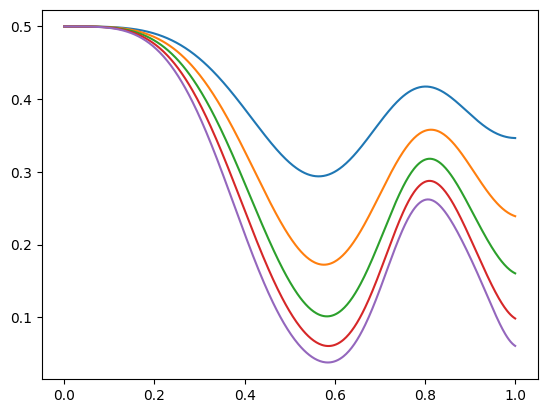

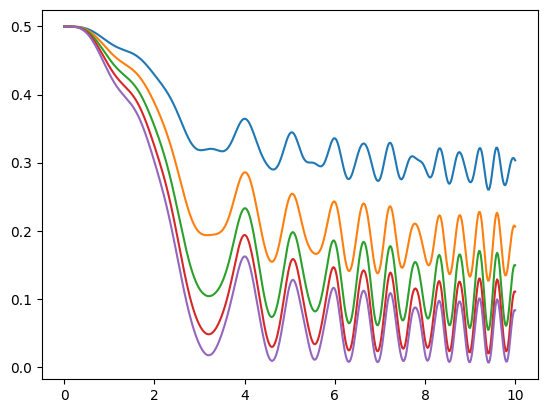

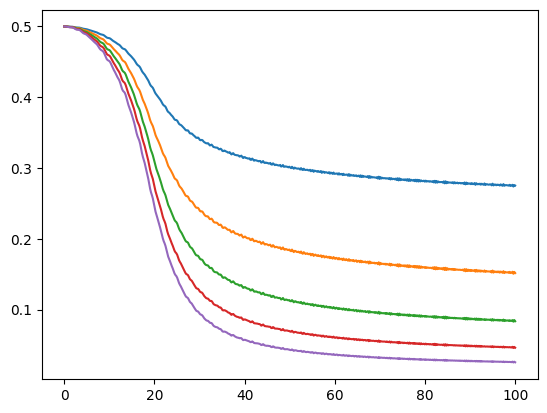

In [46]:
plt.figure()
for n in range(1,6):
    P = Projectors[n]
    dat = [P.expt_value(vt1[i]) for i in range(len(vt1))]
    plt.plot(times1,dat)
plt.figure()
for n in range(1,6):
    P = Projectors[n]
    dat = [P.expt_value(vt2[i]) for i in range(len(vt1))]
    plt.plot(times2,dat)
plt.figure()
for n in range(1,6):
    P = Projectors[n]
    dat = [P.expt_value(vt3[i]) for i in range(len(vt1))]
    plt.plot(times3,dat)


/home/kristian/Desktop/Subsystem Loschmidt Echo/subsystem_loschmidt_echo/scripts/mutual_info/exact_diag/Adiabatic Tests/../../../../src/single_particle_sector.py:184: ComplexWarning: Casting complex values to real discards the imaginary part
  C[nx,ny] = M[Bx,Ay]
/home/kristian/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/kristian/miniconda3/lib/python3.12/site-packages/matplotlib/collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


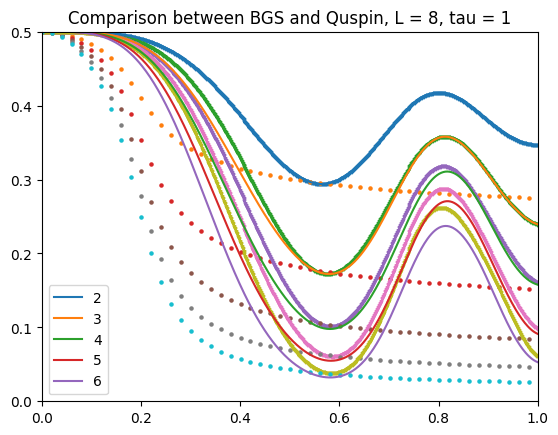

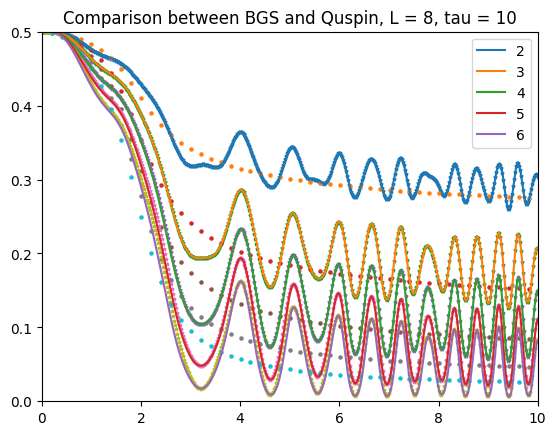

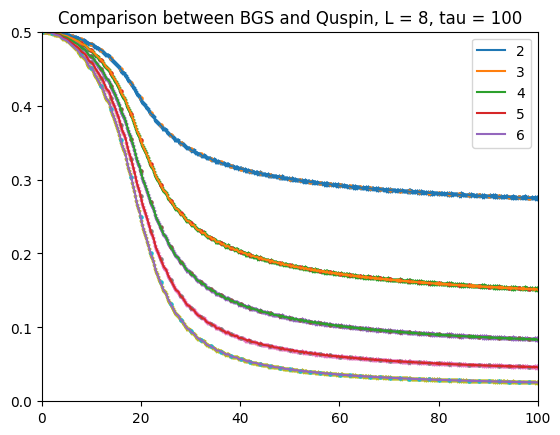

In [ ]:
ns = [2,3,4,5,6]
#i = time step
for j in range(0,len(taus)):
    plt.figure()    
    vt, times, _, _, _ = adiabatic_lanczos_evolution(H, 0, 5, taus[j], steps=500, krylov_dim=15)
    G_t =[sps.G_tfim(Ut_tau[j][ti][:,:L]) for ti in range(N_steps) ]
    G_gs = [sps.G_tfim###Using Quantum_Operator to build hamitlonian 
timestamp = time()
basis = spin_basis_1d(L, pauli = -1)


#NN Sigma x term (Periodic Boundary Conditions)
NN_sigma_x = [ [-J1, i, (i+1)%L] for i in range(L)]
#NNN Sigma x term (PBC)
NNN_sigma_x = [ [-J2,i, (i+2)%L] for i in range(L)]
#site coupling lists
sigma_z = [ [1, i] for i in range(L)]
#Define the static H (that doesn't change)
static_H = [ ["xx", NN_sigma_x], ["xx", NNN_sigma_x] ] 
#The z field is the quench
Quenching_H = [["z", sigma_z]]
#Define operator dictionary
operator_dict = dict(H0= static_H, Quench = Quenching_H)
#Build Hamiltonian
H = quantum_operator(operator_dict, basis=basis, check_herm= False, check_symm = False);
#Build Projectors
Projectors = [fin_string(i,op)[0] for i in range(1,L+1)]
timer(timestamp)GS_adiabatic_comparison_tau={taus[j]}.png")
    plt.show()

In [7]:
###Using Quantum_Operator to build hamitlonian 
timestamp = time()

J1=1
L = 8
J2 = 0
basis = spin_basis_1d(L, pauli = -1,pblock=1)

#NN Sigma x term (Periodic Boundary Conditions)
NN_sigma_x = [ [-J1, i, (i+1)%L] for i in range(L)]
#NNN Sigma x term (PBC)
NNN_sigma_x = [ [-J2,i, (i+2)%L] for i in range(L)]
#site coupling lists
sigma_z = [ [1, i] for i in range(L)]
#Define the static H (that doesn't change)
static_H = [ ["xx", NN_sigma_x], ["xx", NNN_sigma_x] ] 
#The z field is the quench
Quenching_H = [["z", sigma_z]]
#Define operator dictionary
operator_dict = dict(H0= static_H, Quench = Quenching_H)
#Build Hamiltonian
H = quantum_operator(operator_dict, basis=basis, check_herm= False, check_symm = False);
#Build Projectors
#Projectors = [fin_string(i,op)[0] for i in range(1,L+1)]
# Diagonalize static Hamiltonian (only H0)
E, V0 = la.eigh(H.tohamiltonian(dict(H0=1, Quench=0)).todense())

# Time elapsed
print(f"Time elapsed: {time() - timestamp:.2f} seconds")

Time elapsed: 0.18 seconds


In [ ]:
# Define sigma^x operator
x_op = [[1.0, 1] ]
x_term = [["x", x_op]]
x_operator = quantum_operator(dict(H0=x_term), basis=basis, check_herm=False).tohamiltonian(dict(H0=1))

# Compute expectation value
exp_val = x_operator.expt_value(V0)
print(exp_val)
